# <font color="green"> Library Imports </font>

In [211]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_cumulative_gain

import psycopg2

from sqlalchemy import create_engine
from pycorrcat.pycorrcat         import plot_corr, corr_matrix

from imblearn.ensemble import BalancedRandomForestClassifier
from lightgbm import LGBMClassifier 

from sklearn.model_selection     import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing       import MinMaxScaler, RobustScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble            import RandomForestClassifier
from sklearn.dummy               import DummyClassifier
from sklearn.metrics             import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from sklearn.metrics             import accuracy_score, balanced_accuracy_score, roc_curve, auc, precision_score, f1_score, recall_score, classification_report
from sklearn.linear_model        import LogisticRegression
from sklearn.neighbors           import KNeighborsClassifier

import xgboost                   as xgb

import scipy.stats               as stats

from boruta                      import BorutaPy

import warnings

# <font color="green"> Helper functions </font>

In [2]:
def descriptive_statistics(df):
    
    df = df.select_dtypes(include=['int64', 'float64'])

    # Descriptive statistics

    df_descriptive = pd.DataFrame(data=[df.apply(np.min),
                                        df.apply(np.max),
                                        df.apply(lambda x: np.max(x) - np.min(x)),
                                        df.apply(np.mean),
                                        df.apply(np.median),
                                        df.apply(np.std),
                                        df.apply(lambda x: x.skew()),
                                        df.apply(lambda x: x.kurtosis())],
                                  index=np.array(['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']))
    
    return df_descriptive



def get_model_metrics(model_name, model, X_train, y_train, X_test, y_test):
    
    

    inst_model = model.fit(X_train, y_train)


    y_pred = inst_model.predict(X_test)


    # Metrics:



    # Accuracy

    print('Accuracy: {}\n'.format(round(accuracy_score(y_test, y_pred),3)))


    # Balanced Accuracy

    print('Balanced Accuracy: {}\n'.format(round(balanced_accuracy_score(y_test, y_pred),3)))


    # AUC ROC


    # fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1) <- sintax

    fpr, tpr, thresholds = roc_curve(y_test,
                                     np.array([i[1] for i in inst_model.predict_proba(X_test)]), 
                                     pos_label=1)

    auc(fpr, tpr)

    print('AUC-ROC: {}\n'.format(round(auc(fpr, tpr),3)))


    # Classification report

    print('Classification report:\n\n {}\n'.format(classification_report(y_test, y_pred)))


    # Gathering metrics for this estimator

    inst_model_accuracy = accuracy_score(y_test, y_pred)

    inst_model_bal_accuracy = balanced_accuracy_score(y_test, y_pred)

    inst_model_auc = auc(fpr, tpr)

    inst_model_precision = precision_score(y_test, y_pred)

    inst_model_f1 = f1_score(y_test, y_pred)

    inst_model_recall = recall_score(y_test, y_pred)
    
    
    
    # Getting df
    
    
    df = pd.DataFrame(data=[model_name, inst_model_accuracy,
                            inst_model_bal_accuracy, 
                            inst_model_auc, 
                            inst_model_precision, 
                            inst_model_f1, 
                            inst_model_recall]).transpose()

    df.columns = ['Model name', 'Accuracy', 'Balanced Accuracy', 'AUC', 'Precision', 'F1-score', 'Recall']
    
    return df  



def jupyter_settings():
    
    pd.options.display.max_columns = None   
    


warnings.filterwarnings("ignore")
jupyter_settings()

# 1.0 Data import and basic inspection

## <font color="gray"> 1.1 Data loading and checking </font>

In [3]:
# Data loading

## Importing db credentials

db_credentials = pd.read_csv('/mnt/d/Gustavo/health-insurance/db_credentials.txt', header=None)

host = db_credentials[0][0]

port = db_credentials[1][0]

database = db_credentials[2][0]

user = db_credentials[3][0]

psw = db_credentials[4][0]


In [4]:
# Schema

## Checking DB schema where tables belong to


# connecting Postgres
connection = psycopg2.connect('postgresql://{}:{}@{}:{}/{}'.format(user, psw, host, port, database))

# cursor object
cursor= connection.cursor()


# nspname: name of the namespace
#pg_namespace: contains schema definitions

query_schema = """

    SELECT nspname
    FROM pg_catalog.pg_namespace
    
"""

cursor.execute(query_schema)

record = (cursor.fetchall())

print(record)

cursor.close()

connection.close()

[('pg_toast',), ('pg_temp_1',), ('pg_toast_temp_1',), ('pg_catalog',), ('information_schema',), ('public',), ('pa004',), ('pg_temp_4',), ('pg_toast_temp_4',), ('pa005',), ('pg_temp_9',), ('pg_toast_temp_9',)]


In [5]:
# Selecting data from database - SQL query ('insurance' table - pa004 schema)

query = """
    SELECT *
    FROM pa004.insurance

"""

# Connecting to Postgres database

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(user, psw, host, port, database))


# executing sql query

df_insurance = pd.read_sql_query(query, con=engine)

# closing database connection

engine.dispose()

In [6]:
# Selecting data from database - SQL query ('users' table - pa004 schema)

query = """
    SELECT *
    FROM pa004.users

"""

# Connecting to Postgres database

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(user, psw, host, port, database))


# executing sql query

df_users = pd.read_sql_query(query, con=engine)

# closing database connection

engine.dispose()

In [7]:
# Selecting data from database - SQL query ('vehicle' table - pa004 schema)

query = """
    SELECT *
    FROM pa004.vehicle

"""

# Connecting to Postgres database

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(user, psw, host, port, database))


# executing sql query

df_vehicle = pd.read_sql_query(query, con=engine)

# closing database connection

engine.dispose()

In [8]:
# Checking tables

df_insurance.head()

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.0,217,1
1,2,0,33536.0,183,0
2,3,0,38294.0,27,1
3,4,1,28619.0,203,0
4,5,1,27496.0,39,0


In [9]:
df_users.head()

,id,gender,age,region_code,policy_sales_channel
0,1,Male,44,28.0,26.0
1,2,Male,76,3.0,26.0
2,3,Male,47,28.0,26.0
3,4,Male,21,11.0,152.0
4,5,Female,29,41.0,152.0


In [10]:
df_vehicle.head()

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No


In [11]:
# Merging tables

## merging df_users with df_insurance
df = pd.merge(left=df_users, right=df_insurance, how='left', on='id')

# resulting df with df_vehicle
df = pd.merge(left=df, right=df_vehicle, how='left', on='id')

df

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
0,1,Male,44,28.0,26.0,0,40454.0,217,1,1,> 2 Years,Yes
1,2,Male,76,3.0,26.0,0,33536.0,183,0,1,1-2 Year,No
2,3,Male,47,28.0,26.0,0,38294.0,27,1,1,> 2 Years,Yes
3,4,Male,21,11.0,152.0,1,28619.0,203,0,1,< 1 Year,No
4,5,Female,29,41.0,152.0,1,27496.0,39,0,1,< 1 Year,No
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26.0,26.0,1,30170.0,88,0,1,1-2 Year,No
381105,381106,Male,30,37.0,152.0,1,40016.0,131,0,1,< 1 Year,No
381106,381107,Male,21,30.0,160.0,1,35118.0,161,0,1,< 1 Year,No
381107,381108,Female,68,14.0,124.0,0,44617.0,74,0,1,> 2 Years,Yes


In [12]:
# Reorganizing columns

df = df[['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
         'previously_insured', 'annual_premium', 'vintage',
         'driving_license', 'vehicle_age', 'vehicle_damage', 'response']]

In [13]:
# Data dimensions

print('Number of rows: {}'.format(df.shape[0]))
print('Number of columns: {}'.format(df.shape[1]))

Number of rows: 381109
Number of columns: 12


In [14]:
# checking data types

df.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
response                  int64
dtype: object

In [15]:
# Checking data info

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   region_code           381109 non-null  float64
 4   policy_sales_channel  381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   annual_premium        381109 non-null  float64
 7   vintage               381109 non-null  int64  
 8   driving_license       381109 non-null  int64  
 9   vehicle_age           381109 non-null  object 
 10  vehicle_damage        381109 non-null  object 
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 37.8+ MB


In [16]:
# Checking for NA's

df.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
driving_license         0
vehicle_age             0
vehicle_damage          0
response                0
dtype: int64

In [17]:
# Checking for duplicate rows

df.duplicated().sum()

0

In [18]:
# Response variable

df['response'].value_counts()

0    334399
1     46710
Name: response, dtype: int64

In [19]:
# Response variable - percentage

print('Percentage of people that did not purchase health insurance: {:.2f}'.format(df['response'].value_counts(normalize=True)[0]))
print('Percentage of people that purchased health insurance: {:.2f}'.format(df['response'].value_counts(normalize=True)[1]))


Percentage of people that did not purchase health insurance: 0.88
Percentage of people that purchased health insurance: 0.12


In [20]:
# Setting 'id' column as index

df = df.set_index('id')

df

,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response
id,,,,,,,,,,,
1,Male,44,28.0,26.0,0,40454.0,217,1,> 2 Years,Yes,1
2,Male,76,3.0,26.0,0,33536.0,183,1,1-2 Year,No,0
3,Male,47,28.0,26.0,0,38294.0,27,1,> 2 Years,Yes,1
4,Male,21,11.0,152.0,1,28619.0,203,1,< 1 Year,No,0
5,Female,29,41.0,152.0,1,27496.0,39,1,< 1 Year,No,0
...,...,...,...,...,...,...,...,...,...,...,...
381105,Male,74,26.0,26.0,1,30170.0,88,1,1-2 Year,No,0
381106,Male,30,37.0,152.0,1,40016.0,131,1,< 1 Year,No,0
381107,Male,21,30.0,160.0,1,35118.0,161,1,< 1 Year,No,0


In [21]:
# Adjusting data types

df[['region_code',
    'policy_sales_channel',
    'annual_premium']] = df[['region_code',
                             'policy_sales_channel',
                             'annual_premium']].astype('int')

## <font color="gray"> 1.2 Descriptive statistics </font>

### <i>1.2.1 descriptive statistics</i>

In [22]:
# Numerical and categorical attributes

# numerical attributes
num_attributes = df.select_dtypes(['int64', 'float64'])

# categorical attributes
cat_attributes = df.select_dtypes(exclude=['int64', 'float64'])

In [23]:
# Descriptive statistics

descriptive_statistics(df)

,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,response
min,20.000000,0.000000,1.000000,0.000000,2630.000000,10.000000,0.000000,0.000000
max,85.000000,52.000000,163.000000,1.000000,540165.000000,299.000000,1.000000,1.000000
range,65.000000,52.000000,162.000000,1.000000,537535.000000,289.000000,1.000000,1.000000
mean,38.822584,26.388807,112.034295,0.458210,30564.389581,154.347397,0.997869,0.122563
median,36.000000,28.000000,133.000000,0.000000,31669.000000,154.000000,1.000000,0.000000
std,15.511591,13.229871,54.203924,0.498251,17213.132474,83.671194,0.046109,0.327935
skew,0.672539,-0.115266,-0.900008,0.167747,1.766087,0.003030,-21.595182,2.301906
kurtosis,-0.565655,-0.867857,-0.970810,-1.971871,34.004569,-1.200688,464.354302,3.298788


### <i>1.2.2 general view of attributes</i>

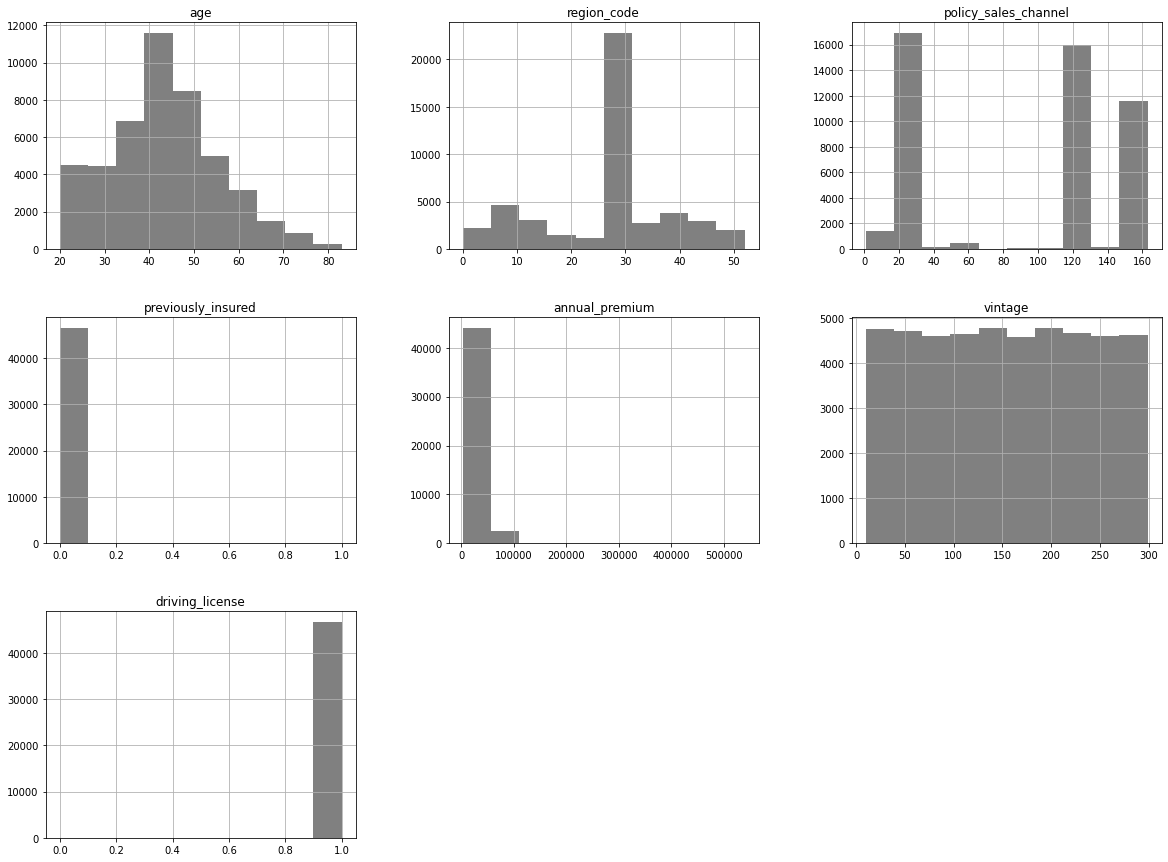

In [23]:
# Numeric attributes view

# Exploring numerical attributes

# as we are interested in people who have purchased health insurance, in this evaluation we are going
# to filter the dataset based on this condition to see the behaviour of numerical attributes for this group

# we are not showing here the distribution for the numerical variable 'response' because it is our target variable

num_attributes.loc[num_attributes['response']==1, num_attributes.columns!='response'].hist(figsize=(20,15), color='gray');

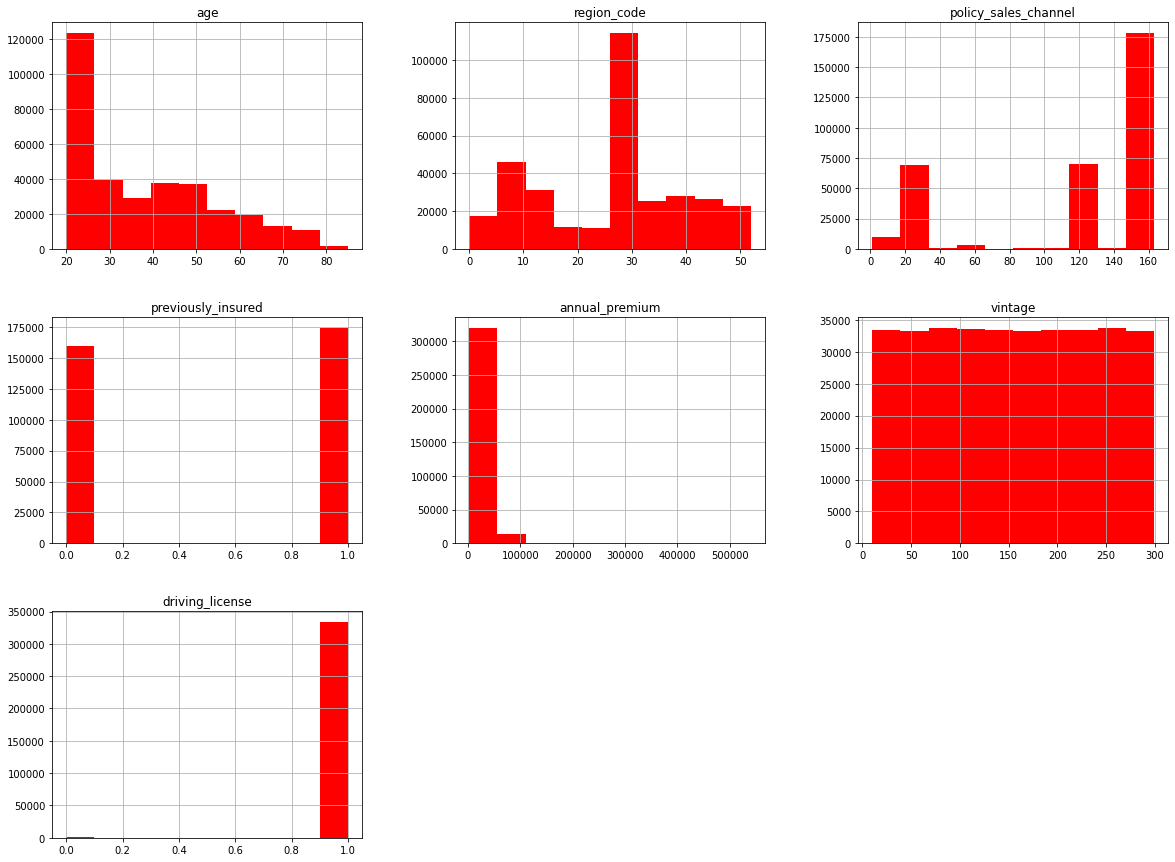

In [24]:
# Now let's compare the distributions for the same variables with people who did not purchase
## health insurance

num_attributes.loc[num_attributes['response']==0, num_attributes.columns!='response'].hist(figsize=(20,15), color='red');

* It looks like there are some differences between the two evaluated groups when looking closely at some variables like age, policy sales channel and previously insured.
* Probably for the features where there are obvious differences this are going to help the machine learning model to figure out whether the customer is going to purchase a health insurance or not (or the % probability of doing so). 

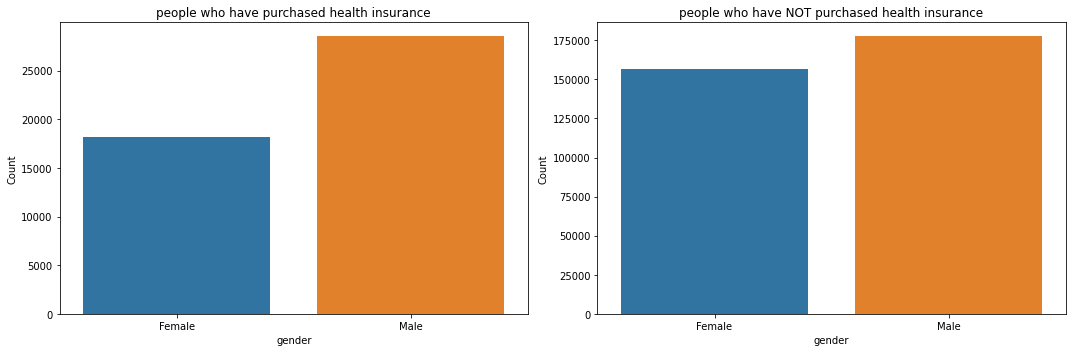

In [25]:
# Categorical attributes view


plt.figure(figsize=(15,5))

# gender profile for people who have purchased health insurance

plt.subplot(1,2,1)
sns.barplot(x='gender',
            y=0,
            data=df.loc[df['response']==1, ['gender']].groupby('gender').size().reset_index())

plt.ylabel('Count')
plt.title('people who have purchased health insurance')


# gender profile for people who have not purchased health insurance

plt.subplot(1,2,2)
sns.barplot(x='gender',
            y=0,
            data=df.loc[df['response']==0, ['gender']].groupby('gender').size().reset_index())

plt.ylabel('Count')
plt.title('people who have NOT purchased health insurance')

plt.tight_layout();

The female/male distribution between people who have and have not purchased health insurance is quite similar although there is a slight difference between them 

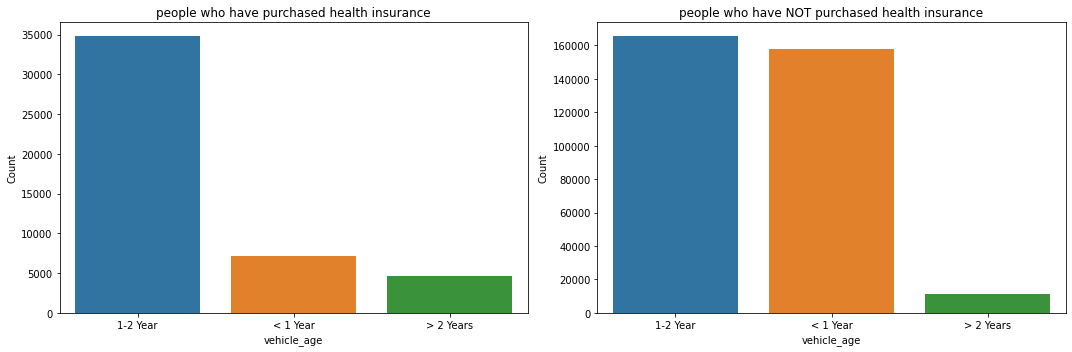

In [26]:
plt.figure(figsize=(15,5))

# vehicle_age profile for people who have purchased health insurance

plt.subplot(1,2,1)
sns.barplot(x='vehicle_age',
            y=0,
            data=df.loc[df['response']==1, ['vehicle_age']].groupby('vehicle_age').size().reset_index())

plt.ylabel('Count')
plt.title('people who have purchased health insurance')


# vehicle_age profile for people who have not purchased health insurance

plt.subplot(1,2,2)
sns.barplot(x='vehicle_age',
            y=0,
            data=df.loc[df['response']==0, ['vehicle_age']].groupby('vehicle_age').size().reset_index())

plt.ylabel('Count')
plt.title('people who have NOT purchased health insurance')

plt.tight_layout();

for people who have purchased health insurance most of their vehicle is aged between 1-2 year while for the people who have not purchased health unsurance the ratio between 1-2 year and <1 year is almost the same. Vehicle age seems to be a good variable to tell us wheter a certain person will or will not purchase health insurance. 

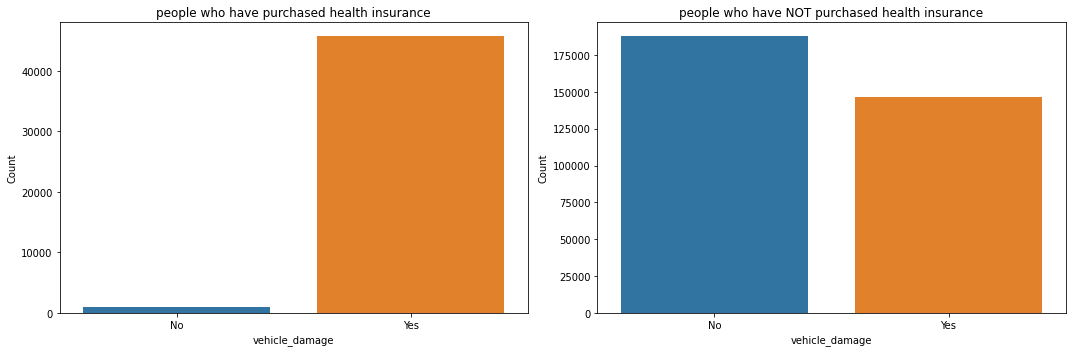

In [27]:
plt.figure(figsize=(15,5))

# vehicle_damage profile for people who have purchased health insurance

plt.subplot(1,2,1)
sns.barplot(x='vehicle_damage',
            y=0,
            data=df.loc[df['response']==1, ['vehicle_damage']].groupby('vehicle_damage').size().reset_index())

plt.ylabel('Count')
plt.title('people who have purchased health insurance')


# vehicle_damage profile for people who have not purchased health insurance

plt.subplot(1,2,2)
sns.barplot(x='vehicle_damage',
            y=0,
            data=df.loc[df['response']==0, ['vehicle_damage']].groupby('vehicle_damage').size().reset_index())

plt.ylabel('Count')
plt.title('people who have NOT purchased health insurance')

plt.tight_layout();

When it comes to vehicle damage it is easy to see that for people who have purchased health insurance most of them had their vehicle previously damage (no brainer!), while for the people who have not most of them did not have their vehicle damaged. Also the observed No/Yes ratio is completely different between these 2 groups.

# 2.0 Feature engineering

In [24]:
df_2 = df.copy()

## <font color="gray"> 2.1 Creating new features </font>

In [25]:
# Creating the feature 'stage of life'

df_2['stage_of_life']= df['age'].apply(lambda x: 'adult' if x>=20 and x<=39
                                       else 'middle_age_adult' if x>=40 and x<=59
                                       else 'senior_adult')

In [26]:
df_2.head()

,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response,stage_of_life
id,,,,,,,,,,,,
1,Male,44,28,26,0,40454,217,1,> 2 Years,Yes,1,middle_age_adult
2,Male,76,3,26,0,33536,183,1,1-2 Year,No,0,senior_adult
3,Male,47,28,26,0,38294,27,1,> 2 Years,Yes,1,middle_age_adult
4,Male,21,11,152,1,28619,203,1,< 1 Year,No,0,adult
5,Female,29,41,152,1,27496,39,1,< 1 Year,No,0,adult


## <font color="gray"> 2.2 Hypothesis to be validated </font>

# 3.0 Data filtering

In [27]:
df_3 = df_2.copy()

In [28]:
# According to previous data visualization previously carried out (session 1.2.2) the feature 'vintage' seems to be
## constant and therefore do not carry useful information for group segregation. We are going to remove it

df_3 = df_3.drop(columns=['vintage'])

# 4.0 Exploratory Data Analysis (EDA)

In [29]:
df_4 = df_3.copy()

## <font color="gray"> 4.1 Univariate analysis </font>

<AxesSubplot:xlabel='response', ylabel='count'>

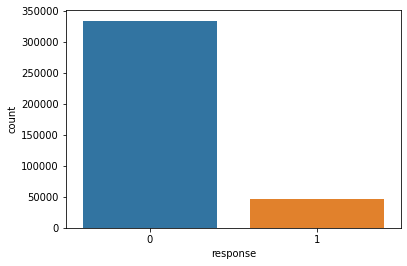

In [30]:
# Response variable

sns.countplot(df['response'])

### <i>4.1.1 numerical attributes</i>

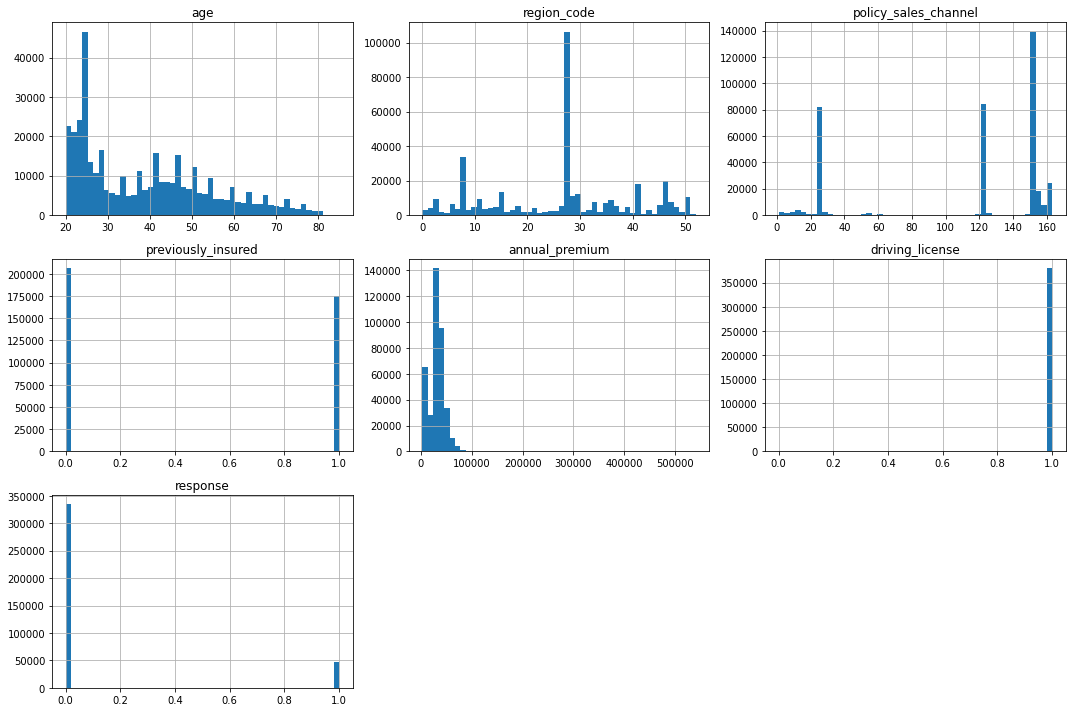

In [31]:
df_4.select_dtypes(['float64', 'int64']).hist(figsize=(15,10), bins=50);
plt.tight_layout()

### <i>4.1.2 categorical attributes</i>

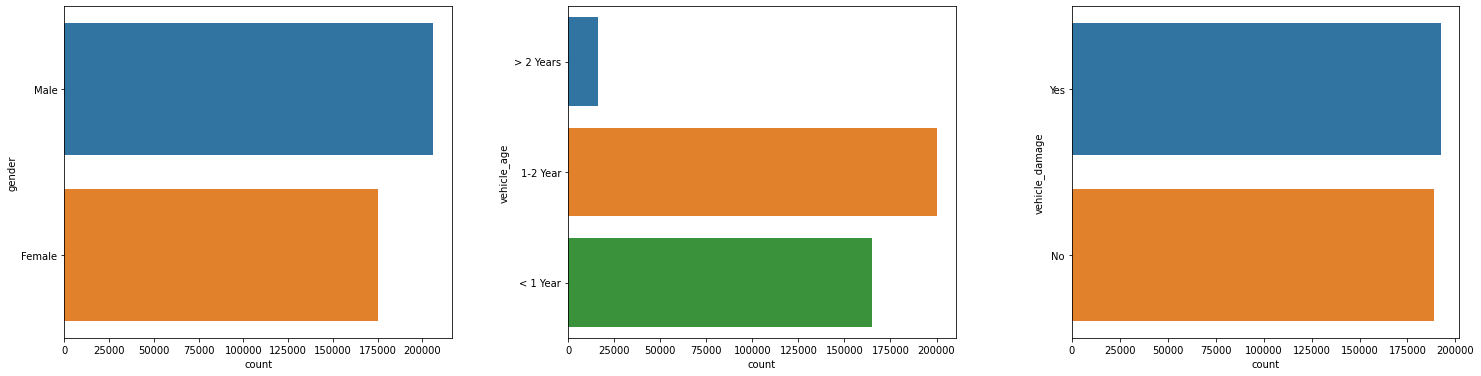

In [39]:
# sets plot size
plt.figure(figsize=(25, 50))

# sets the inital plot position
n = 1

# iterates over the columns to plot
for i in cat_attributes.columns:
    plt.subplot(5, 3, n)
    _ = sns.countplot(y=cat_attributes[i], orient='v')
    n += 1

# adjust height and wdith reserved for space between subplots  
plt.subplots_adjust(hspace=0.8)
plt.subplots_adjust(wspace=0.3)

# # display the plot
plt.show()

## <font color="gray"> 4.2 Bivariate analysis </font>

### <i>4.2.1 validating hypothesis raised</i>

### <i>4.2.2 statistical hypothesis testing</i>

It will be applied to numeric continuous attributes:

'age', 'region_code', 'policy_sales_channel', 'annual_premium'


But first let's test to check if the data distribution of these features has a gaussian shape (parametric distribution) so we can further apply the correct statistical test.

In [52]:
# Shapiro test

for i in ['age', 'region_code', 'policy_sales_channel', 'annual_premium']:

  stat, p = stats.shapiro(df_4.loc[:, i])
  
  print('Feature: {}'.format(i))
  print('stat=%.3f, p=%.3f' % (stat, p))

  if p > 0.05:
    print('Probably Gaussian\n')

  else:
    print('Probably not Gaussian\n')

Feature: age
stat=0.911, p=0.000
Probably not Gaussian

Feature: region_code
stat=0.942, p=0.000
Probably not Gaussian

Feature: policy_sales_channel
stat=0.720, p=0.000
Probably not Gaussian

Feature: annual_premium
stat=0.873, p=0.000
Probably not Gaussian



Since these features probably have a not Gaussian shape we will apply Mann-Whitney non-parametric test:

In [68]:
for i in ['age', 'annual_premium']:

  stat, p = stats.mannwhitneyu(df_4.loc[df_4['response']==0, i], 
                               df_4.loc[df_4['response']==1, i])
  
  print('Feature: {}'.format(i))
  print('stat=%.3f, p=%.3f' % (stat, p))

  if p > 0.05:
    print('Probably the same distribution\n')

  else:
    print('Probably different distributions\n')

Feature: age
stat=5826171170.500, p=0.000
Probably different distributions

Feature: annual_premium
stat=7343668645.500, p=0.000
Probably different distributions



<AxesSubplot:xlabel='response', ylabel='age'>

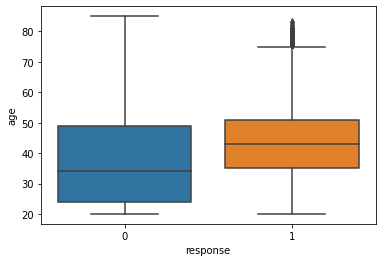

In [65]:
# Age

sns.boxplot(x='response', y='age', data=df_4)

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

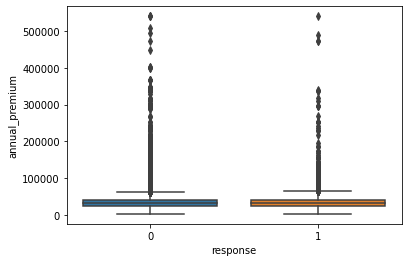

In [69]:
# annual_premium

sns.boxplot(x='response', y='annual_premium', data=df_4)

## <font color="gray"> 4.3 Multivariate analysis </font>

### <i>4.3.1 numerical attributes</i>

<AxesSubplot:>

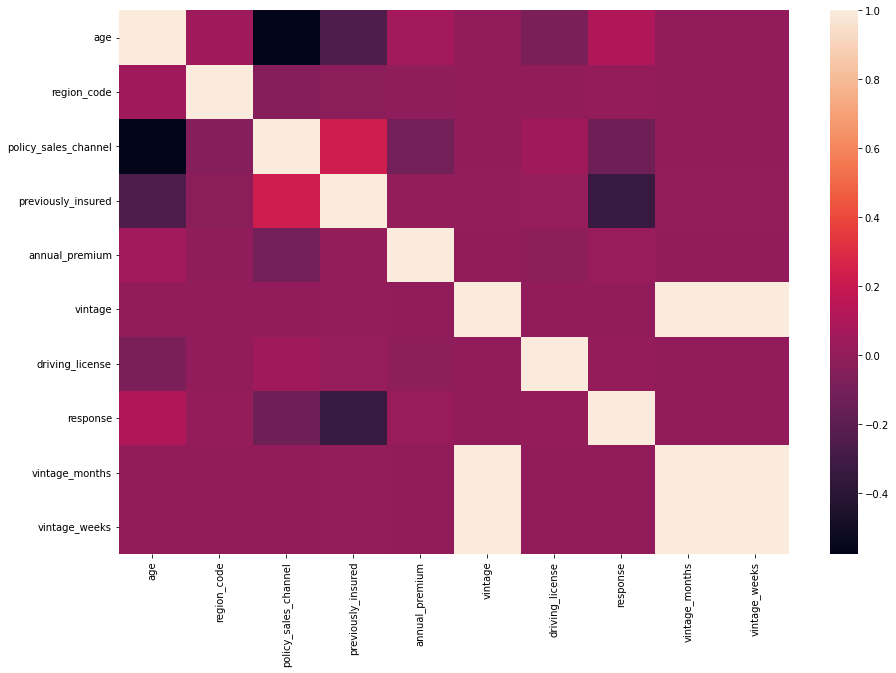

In [37]:
# Correlation analysis

plt.figure(figsize=(15,10))

sns.heatmap(df_4.select_dtypes(include=['float64', 'int64']).corr())

### <i>4.3.2 categorical attributes</i>

<AxesSubplot:>

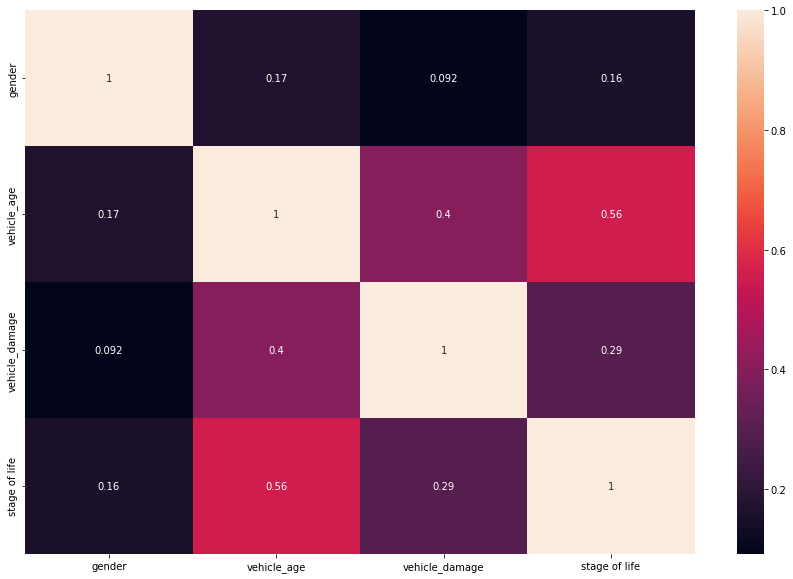

In [38]:
# Correlation analysis

plt.figure(figsize=(15,10))

plot_corr(df_4,
          df_4.select_dtypes(exclude=['float64', 'int64']).columns)

# 5.0 Data preparation

In [129]:
df_5 = df_4.copy()

## <font color="gray"> 5.1 Train/Test split </font>

In [130]:
# Train/Test split

# X_train, X_test, y_train, y_test = train_test_split(y, X, test_size=0.33, random_state=42) <- sintax

y_train, y_test, X_train, X_test = train_test_split(df_5['response'], 
                                                    df_5.drop(columns=['response']), 
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    stratify=df_5['response'])

In [131]:
# Checking class proportion - Training set

y_train.value_counts(normalize=True)

0    0.877435
1    0.122565
Name: response, dtype: float64

In [132]:
# Checking class proportion - Testing set

y_test.value_counts(normalize=True)

0    0.877439
1    0.122561
Name: response, dtype: float64

In [133]:
# Reminding class proportion - Original data

df['response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: response, dtype: float64

## <font color="gray"> 5.2 Scaling - numerical attributes </font>

In [134]:
# Scaling age

scaler = MinMaxScaler()

scaler.fit(X_train[['age']].values)

X_train['age'] = scaler.transform(X_train[['age']].values) # scaling train
X_test['age'] = scaler.transform(X_test[['age']].values) # scaling test


# Scaling region_code

scaler = MinMaxScaler()

scaler.fit(X_train[['region_code']].values)

X_train['region_code'] = scaler.transform(X_train[['region_code']].values) # scaling train
X_test['region_code'] = scaler.transform(X_test[['region_code']].values) # scaling test


# Scaling region_code

scaler = MinMaxScaler()

scaler.fit(X_train[['policy_sales_channel']].values)

X_train['policy_sales_channel'] = scaler.transform(X_train[['policy_sales_channel']].values) # scaling train
X_test['policy_sales_channel'] = scaler.transform(X_test[['policy_sales_channel']].values) # scaling test


# Scaling annual_premium

scaler = RobustScaler()

scaler.fit(X_train[['annual_premium']].values)

X_train['annual_premium'] = scaler.transform(X_train[['annual_premium']].values) # scaling train
X_test['annual_premium'] = scaler.transform(X_test[['annual_premium']].values) # scaling test

In [135]:
# Checking transformed features

X_train.select_dtypes(include=['float64', 'int64']).head()

,age,region_code,policy_sales_channel,previously_insured,annual_premium,driving_license
id,,,,,,
347089,0.153846,0.673077,0.932099,1,-0.153391,1
148668,0.061538,0.192308,0.932099,1,-0.247924,1
282683,0.630769,0.538462,0.154321,0,0.635488,1
101296,0.030769,0.115385,0.932099,1,0.440577,1
60279,0.046154,0.288462,0.932099,0,0.333754,1


## <font color="gray"> 5.3 Encoding - categorical attributes </font>

In [136]:
X_train.select_dtypes(exclude=['float64', 'int64'])

,gender,vehicle_age,vehicle_damage,stage_of_life
id,,,,
347089,Female,< 1 Year,No,adult
148668,Female,< 1 Year,No,adult
282683,Female,1-2 Year,Yes,senior_adult
101296,Male,< 1 Year,No,adult
60279,Female,< 1 Year,No,adult
...,...,...,...,...
378817,Male,< 1 Year,Yes,adult
361829,Male,< 1 Year,No,adult
91745,Male,< 1 Year,No,adult


In [137]:
# gender and vehicle_damage - One-hot encoding

X_train = pd.get_dummies(data=X_train, columns=['gender']) # encoding train
X_test = pd.get_dummies(data=X_test, columns=['gender']) # encoding test


# vehicle_damage - 1 for Yes, 0 for No

X_train['vehicle_damage'] = [1 if i=='Yes' else 0 for i in X_train['vehicle_damage']] # encoding train
X_test['vehicle_damage'] = [1 if i=='Yes' else 0 for i in X_test['vehicle_damage']] # encoding test


# vehicle_age - Ordinal encoding

encoder = OrdinalEncoder()

encoder.fit(X_train[['vehicle_age']].values)

X_train['vehicle_age'] = encoder.transform(X_train[['vehicle_age']].values) # encoding train
X_test['vehicle_age'] = encoder.transform(X_test[['vehicle_age']].values) # encoding test


# stage of life - Label encoding

encoder = LabelEncoder()

encoder.fit(X_train[['stage_of_life']].values)

X_train['stage_of_life'] = encoder.transform(X_train[['stage_of_life']].values) # encoding train
X_test['stage_of_life'] = encoder.transform(X_test[['stage_of_life']].values) # encoding test

# 6.0 Feature selection

In [138]:
# X_train

X_train_1 = X_train.copy()


# y_train

y_train_1 = y_train.copy()

In [139]:
X_train.head()

,age,region_code,policy_sales_channel,previously_insured,annual_premium,driving_license,vehicle_age,vehicle_damage,stage_of_life,gender_Female,gender_Male
id,,,,,,,,,,,
347089,0.153846,0.673077,0.932099,1,-0.153391,1,1.0,0,0,1,0
148668,0.061538,0.192308,0.932099,1,-0.247924,1,1.0,0,0,1,0
282683,0.630769,0.538462,0.154321,0,0.635488,1,0.0,1,2,1,0
101296,0.030769,0.115385,0.932099,1,0.440577,1,1.0,0,0,0,1
60279,0.046154,0.288462,0.932099,0,0.333754,1,1.0,0,0,1,0


## <font color="gray"> 6.1 Boruta algorithm </font>

In [176]:
# Instantiating Boruta

boruta = BorutaPy(BalancedRandomForestClassifier(n_jobs=-1),
                  n_estimators='auto',
                  verbose=2,random_state=42).fit(X_train_1.values, y_train_1.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	8


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	8


In [148]:
# Instantiating Boruta

boruta = BorutaPy(RandomForestClassifier(n_jobs=-1, max_depth=6, class_weight={0: 0.88, 1:0.12}),
                  n_estimators='auto',
                  verbose=2,random_state=42).fit(X_train_1.values, y_train_1.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	2
Iteration: 	16 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	3


BorutaPy

In [149]:
boruta.support_.tolist()

[True, True, True, True, True, False, True, True, True, False, False]

## <font color="gray"> 6.2 Columns selected by Boruta</font>

In [150]:
cols_selected_boruta = X_train_1.loc[:, [True, True, True, True, True, False, 
                                         True, True, True, False, False]].columns.tolist()

cols_not_selected_boruta = list(set(X_train_1.columns).difference(set(cols_selected_boruta )))

print('Features selected by Boruta:\n {}\n'.format(cols_selected_boruta))

print('Features not selected by Boruta:\n {}\n'.format(cols_not_selected_boruta))

Features selected by Boruta:
 ['age', 'region_code', 'policy_sales_channel', 'previously_insured', 'annual_premium', 'vehicle_age', 'vehicle_damage', 'stage_of_life']

Features not selected by Boruta:
 ['gender_Male', 'gender_Female', 'driving_license']



## <font color="gray"> 6.2 Random Forest - Feature importance  </font>

In [184]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=6, class_weight={0: 0.88, 1:0.12})

rf.fit(X_train_1.values, y_train_1.values)

importance = rf.feature_importances_

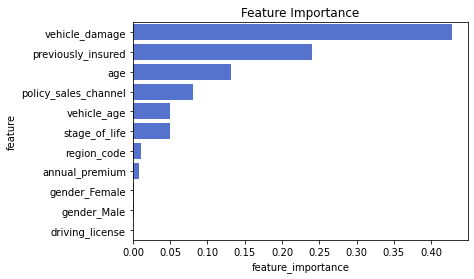

In [153]:
for i,v in enumerate(importance):
    ('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
feature_importance = pd.DataFrame({'feature':X_train.columns,
                                  'feature_importance':importance}).sort_values('feature_importance', ascending=False).reset_index()
sns.barplot(x='feature_importance', y='feature', data=feature_importance, orient='h', color='royalblue').set_title('Feature Importance');

In [156]:
cols_selected_rf = X_train_1.loc[:, ['vehicle_damage', 'previously_insured', 'age']].columns.tolist()

cols_not_selected_rf = list(set(X_train_1.columns).difference(set(cols_selected_rf )))

print('Features selected by RF:\n {}\n'.format(cols_selected_rf))

print('Features not selected by RF:\n {}\n'.format(cols_not_selected_rf))

Features selected by RF:
 ['vehicle_damage', 'previously_insured', 'age']

Features not selected by RF:
 ['driving_license', 'gender_Male', 'annual_premium', 'policy_sales_channel', 'stage_of_life', 'region_code', 'vehicle_age', 'gender_Female']



In [179]:
cols_selected_rf = X_train_1.loc[:, ['vehicle_damage', 'previously_insured', 'age']].columns.tolist()

cols_not_selected_rf = list(set(X_train_1.columns).difference(set(cols_selected_rf )))

print('Features selected by RF:\n {}\n'.format(cols_selected_rf))

print('Features not selected by RF:\n {}\n'.format(cols_not_selected_rf))

Features selected by RF:
 ['vehicle_damage', 'previously_insured', 'age']

Features not selected by RF:
 ['driving_license', 'gender_Male', 'annual_premium', 'policy_sales_channel', 'stage_of_life', 'region_code', 'vehicle_age', 'gender_Female']



# 7.0 Machine learning

In [225]:
## Defining datasets with Boruta-selected features
#
#
## X_train
#X_train_boruta = X_train[cols_selected_boruta].copy()
#
#
## X_test
#X_test_boruta = X_test[cols_selected_boruta].copy()

In [226]:
# Defining datasets with RF-selected features


# X_train
X_train_rf = X_train[cols_selected_rf].copy()


# X_test
X_test_rf = X_test[cols_selected_rf].copy()

## <font color="gray"> 7.1 Baseline model </font>

In [227]:
model_name = 'Dummy classifier'

model = DummyClassifier(strategy='most_frequent', random_state=42)

df_baseline = get_model_metrics(model_name, model, X_train_rf, y_train, X_test_rf, y_test)

pred_proba_model = model.predict_proba(X_test_rf)

df_baseline

Accuracy: 0.877

Balanced Accuracy: 0.5

AUC-ROC: 0.5

Classification report:

               precision    recall  f1-score   support

           0       0.88      1.00      0.93    110352
           1       0.00      0.00      0.00     15414

    accuracy                           0.88    125766
   macro avg       0.44      0.50      0.47    125766
weighted avg       0.77      0.88      0.82    125766




,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,Dummy classifier,0.877439,0.5,0.5,0.0,0.0,0.0


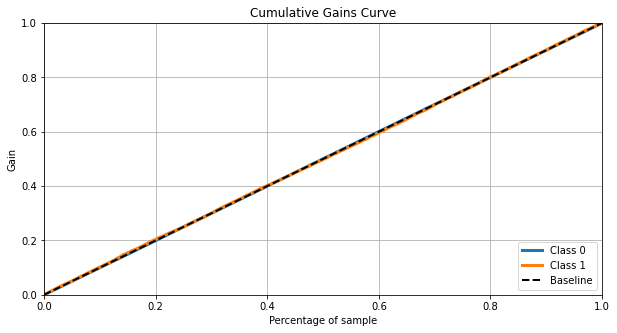

In [228]:
# Cumulative gain curve

plot_cumulative_gain(y_test,
                     pred_proba_model,
                     figsize=(10,5));

## <font color="gray"> 7.2 Logistic Regression </font>

In [230]:
model_name = 'Logistic Regression balanced'

model = LogisticRegression(random_state=42, 
                           n_jobs=-1, 
                           max_iter=10000,
                          class_weight='balanced')


df_log_reg = get_model_metrics(model_name, model, X_train_rf, y_train, X_test_rf, y_test)

pred_proba_model = model.predict_proba(X_test_rf)

df_log_reg

Accuracy: 0.639

Balanced Accuracy: 0.785

AUC-ROC: 0.799

Classification report:

               precision    recall  f1-score   support

           0       0.99      0.59      0.74    110352
           1       0.25      0.98      0.40     15414

    accuracy                           0.64    125766
   macro avg       0.62      0.78      0.57    125766
weighted avg       0.90      0.64      0.70    125766




,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,Logistic Regression balanced,0.638503,0.784544,0.798571,0.250415,0.398736,0.978007


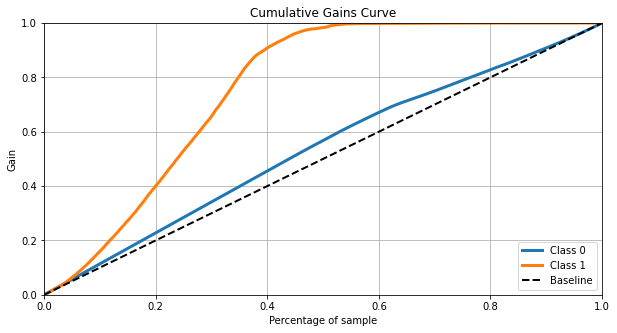

In [231]:
# Cumulative gain curve

plot_cumulative_gain(y_test,
                     pred_proba_model,
                     figsize=(10,5));

## <font color="gray"> 7.3 Balanced Random Forest </font>

In [232]:
model_name = 'Random Forest'

model = BalancedRandomForestClassifier(n_jobs=-1)


df_rf = get_model_metrics(model_name, model, X_train_rf, y_train, X_test_rf, y_test)

pred_proba_model = model.predict_proba(X_test_rf)


df_rf

Accuracy: 0.68

Balanced Accuracy: 0.792

AUC-ROC: 0.842

Classification report:

               precision    recall  f1-score   support

           0       0.99      0.64      0.78    110352
           1       0.27      0.94      0.42     15414

    accuracy                           0.68    125766
   macro avg       0.63      0.79      0.60    125766
weighted avg       0.90      0.68      0.73    125766




,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,Random Forest,0.679699,0.791749,0.841713,0.269103,0.418439,0.940184


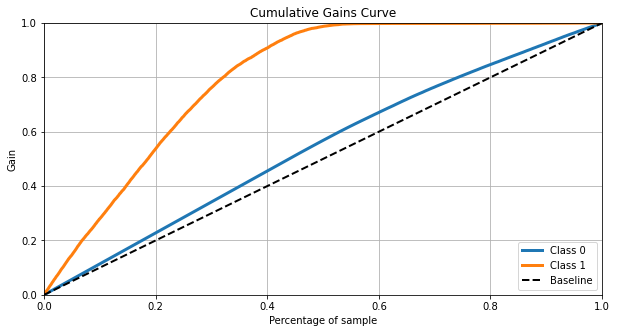

In [233]:
# Cumulative gain curve

plot_cumulative_gain(y_test,
                     pred_proba_model,
                     figsize=(10,5));

## <font color="gray"> 7.4 XGBoost </font>

In [234]:
model_name = 'XG Boost'

model = xgb.XGBClassifier(objective='binary:logistic',
                            n_estimators=100,
                            max_depth=10,
                            tree_method='exact',
                            n_jobs=-1,
                            random_state=42, 
                            class_weight='balanced')


df_xgb = get_model_metrics(model_name, model, X_train_rf, y_train, X_test_rf, y_test)

pred_proba_model = model.predict_proba(X_test_rf)

df_xgb

Accuracy: 0.877

Balanced Accuracy: 0.5

AUC-ROC: 0.842

Classification report:

               precision    recall  f1-score   support

           0       0.88      1.00      0.93    110352
           1       0.00      0.00      0.00     15414

    accuracy                           0.88    125766
   macro avg       0.44      0.50      0.47    125766
weighted avg       0.77      0.88      0.82    125766




,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,XG Boost,0.877439,0.5,0.84206,0.0,0.0,0.0


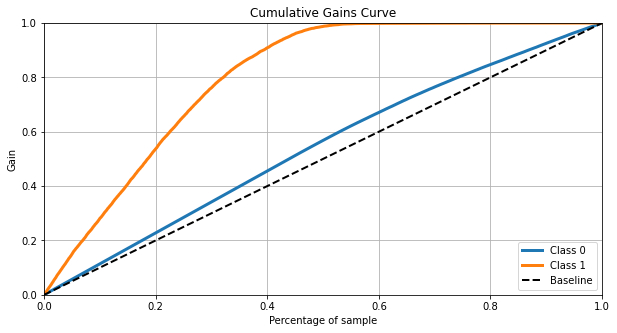

In [235]:
# Cumulative gain curve

plot_cumulative_gain(y_test,
                     pred_proba_model,
                     figsize=(10,5));

## <font color="gray"> 7.5 KNN </font>

In [236]:
model_name = 'KNN'

model = KNeighborsClassifier(n_jobs=-1,  n_neighbors=10)


df_knn = get_model_metrics(model_name, model, X_train_rf, y_train, X_test_rf, y_test)

pred_proba_model = model.predict_proba(X_test_rf)

df_knn

Accuracy: 0.866

Balanced Accuracy: 0.533

AUC-ROC: 0.79

Classification report:

               precision    recall  f1-score   support

           0       0.88      0.97      0.93    110352
           1       0.33      0.09      0.14     15414

    accuracy                           0.87    125766
   macro avg       0.61      0.53      0.54    125766
weighted avg       0.82      0.87      0.83    125766




,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,KNN,0.865775,0.533232,0.790284,0.330405,0.14479,0.092708


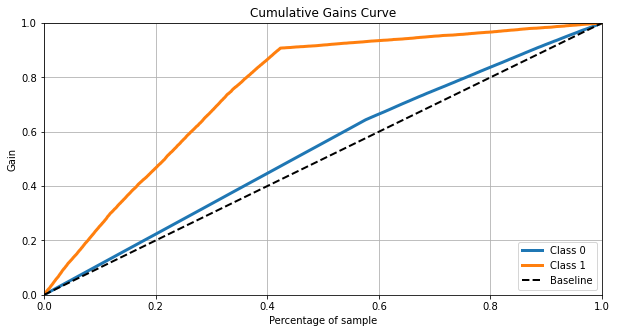

In [237]:
# Cumulative gain curve

plot_cumulative_gain(y_test,
                     pred_proba_model,
                     figsize=(10,5));

## <font color="gray"> 7.6 LightGBM </font>

In [238]:
model_name = 'LightGBM'

model = LGBMClassifier(n_jobs=-1, objective='binary', class_weight='balanced')


df_lgbm = get_model_metrics(model_name, model, X_train_rf, y_train, X_test_rf, y_test)

pred_proba_model = model.predict_proba(X_test_rf)

df_lgbm

Accuracy: 0.681

Balanced Accuracy: 0.791

AUC-ROC: 0.842

Classification report:

               precision    recall  f1-score   support

           0       0.99      0.65      0.78    110352
           1       0.27      0.94      0.42     15414

    accuracy                           0.68    125766
   macro avg       0.63      0.79      0.60    125766
weighted avg       0.90      0.68      0.74    125766




,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,LightGBM,0.680939,0.791312,0.842025,0.269533,0.418694,0.937524


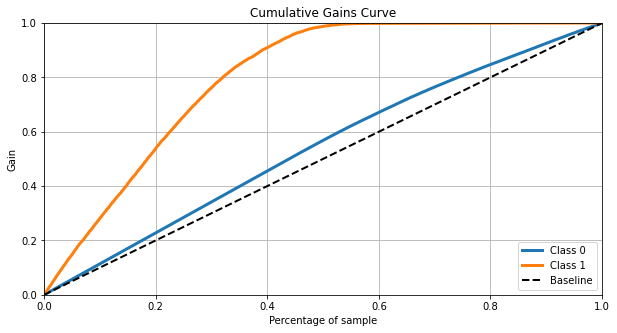

In [239]:
# Cumulative gain curve

plot_cumulative_gain(y_test,
                     pred_proba_model,
                     figsize=(10,5));

## <font color="blue"> Summary of metrics </font>

In [240]:
pd.concat([df_baseline, df_log_reg, df_rf, df_xgb, df_knn, df_lgbm])

,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,Dummy classifier,0.877439,0.5,0.5,0.0,0.0,0.0
0,Logistic Regression balanced,0.638503,0.784544,0.798571,0.250415,0.398736,0.978007
0,Random Forest,0.679699,0.791749,0.841713,0.269103,0.418439,0.940184
0,XG Boost,0.877439,0.5,0.84206,0.0,0.0,0.0
0,KNN,0.865775,0.533232,0.790284,0.330405,0.14479,0.092708
0,LightGBM,0.680939,0.791312,0.842025,0.269533,0.418694,0.937524


Cross validation

# 8.0 Hyperparameter fine tuning

## <font color="gray"> 8.1 Random search </font>

## <font color="gray"> 8.2 Tuned final model </font>

# 9.0 Error interpretation

## <font color="gray"> 9.1 Main </font>

# 10.0 Deploy

## <font color="gray"> 10.1 Class data_prep.py </font>

## <font color="gray"> 10.2 API_handler.py </font>

## <font color="gray"> 10.3 API tester local </font>

## <font color="gray"> 10.4 API tester remote/cloud </font>